# Geometric Interpretation of Overfitting in Function Space

## Objective
Understand what happens **geometrically** in function space when a model achieves low training error but high validation error. We'll go beyond the superficial "it's overfitting" to visualize:

1. **Function space geometry**: How learned functions deviate from the true underlying function
2. **Hypothesis space coverage**: How complex models can fit any training configuration
3. **Noise fitting**: What it means geometrically to "memorize noise"
4. **Curvature and complexity**: How model capacity affects the smoothness of decision boundaries

## Key Insight
High validation error despite low training error means the learned function has high curvature or complexity in regions between training points, creating a **different geometric structure** than the true underlying function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Part 1: Generating Synthetic Data

We'll create a 1D regression problem where:
- **True function**: A simple, smooth function (e.g., sine wave or polynomial)
- **Observed data**: True function + Gaussian noise
- **Goal**: Recover the true function from noisy observations

This setup lets us visualize the **function space** directly and see how learned functions compare to the ground truth.

In [2]:
def generate_data(n_samples=100, noise_level=0.3):
    """
    Generate synthetic 1D regression data
    True function: f(x) = sin(2πx) + 0.5*sin(6πx)
    """
    # Training data
    X_train = np.sort(np.random.uniform(0, 1, n_samples))
    
    # True underlying function (smooth, low-frequency components)
    y_true_train = np.sin(2 * np.pi * X_train) + 0.5 * np.sin(6 * np.pi * X_train)
    
    # Add noise
    noise = np.random.normal(0, noise_level, n_samples)
    y_train = y_true_train + noise
    
    # Dense grid for visualization (true function)
    X_grid = np.linspace(0, 1, 500)
    y_grid_true = np.sin(2 * np.pi * X_grid) + 0.5 * np.sin(6 * np.pi * X_grid)
    
    return X_train, y_train, y_true_train, X_grid, y_grid_true

# Generate data
X_train, y_train, y_true_train, X_grid, y_grid_true = generate_data(n_samples=50)

# Create validation set (different samples from same distribution)
X_val, y_val, y_true_val, _, _ = generate_data(n_samples=30)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Training samples: 50
Validation samples: 30


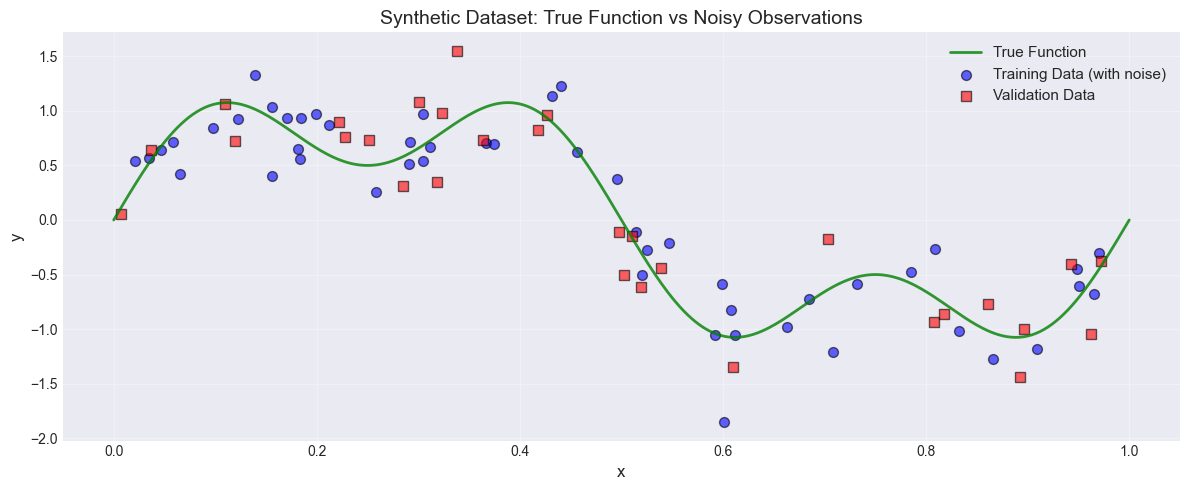

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Plot true function
ax.plot(X_grid, y_grid_true, 'g-', linewidth=2, label='True Function', alpha=0.8)

# Plot training data
ax.scatter(X_train, y_train, c='blue', s=50, alpha=0.6, 
           edgecolors='black', label='Training Data (with noise)')

# Plot validation data
ax.scatter(X_val, y_val, c='red', s=50, alpha=0.6, 
           marker='s', edgecolors='black', label='Validation Data')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Synthetic Dataset: True Function vs Noisy Observations', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 2: Fitting Models of Varying Complexity

We'll fit polynomial models of different degrees:
- **Low complexity (degree 3)**: Underfitting - too simple to capture the pattern
- **Moderate complexity (degree 9)**: Good fit - captures signal without overfitting
- **High complexity (degree 20)**: Overfitting - memorizes training noise

### Geometric Interpretation
In function space, each polynomial defines a curve. High-degree polynomials can create **highly oscillatory functions** that pass through all training points but diverge wildly between them.

In [4]:
def fit_polynomial(X_train, y_train, X_test, degree):
    """Fit polynomial regression of given degree"""
    # Reshape for sklearn
    X_train_reshaped = X_train.reshape(-1, 1)
    X_test_reshaped = X_test.reshape(-1, 1)
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train_reshaped)
    X_test_poly = poly.transform(X_test_reshaped)
    
    # Fit linear regression on polynomial features
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    return y_test_pred, y_train_pred, model, poly

# Train models with different complexities
degrees = [3, 9, 20]
models_results = {}

for degree in degrees:
    y_grid_pred, y_train_pred, model, poly = fit_polynomial(
        X_train, y_train, X_grid, degree
    )
    # CORRECTED: y_val_pred should be the FIRST return value
    y_val_pred, _, _, _ = fit_polynomial(
        X_train, y_train, X_val, degree
    )
    
    train_error = mean_squared_error(y_train, y_train_pred)
    val_error = mean_squared_error(y_val, y_val_pred)
    
    models_results[degree] = {
        'predictions': y_grid_pred,
        'train_error': train_error,
        'val_error': val_error,
        'model': model,
        'poly': poly
    }
    
    print(f"Degree {degree:2d} | Train MSE: {train_error:.4f} | Val MSE: {val_error:.4f}")

Degree  3 | Train MSE: 0.1514 | Val MSE: 0.1547
Degree  9 | Train MSE: 0.0646 | Val MSE: 0.1665
Degree 20 | Train MSE: 0.0527 | Val MSE: 0.1527


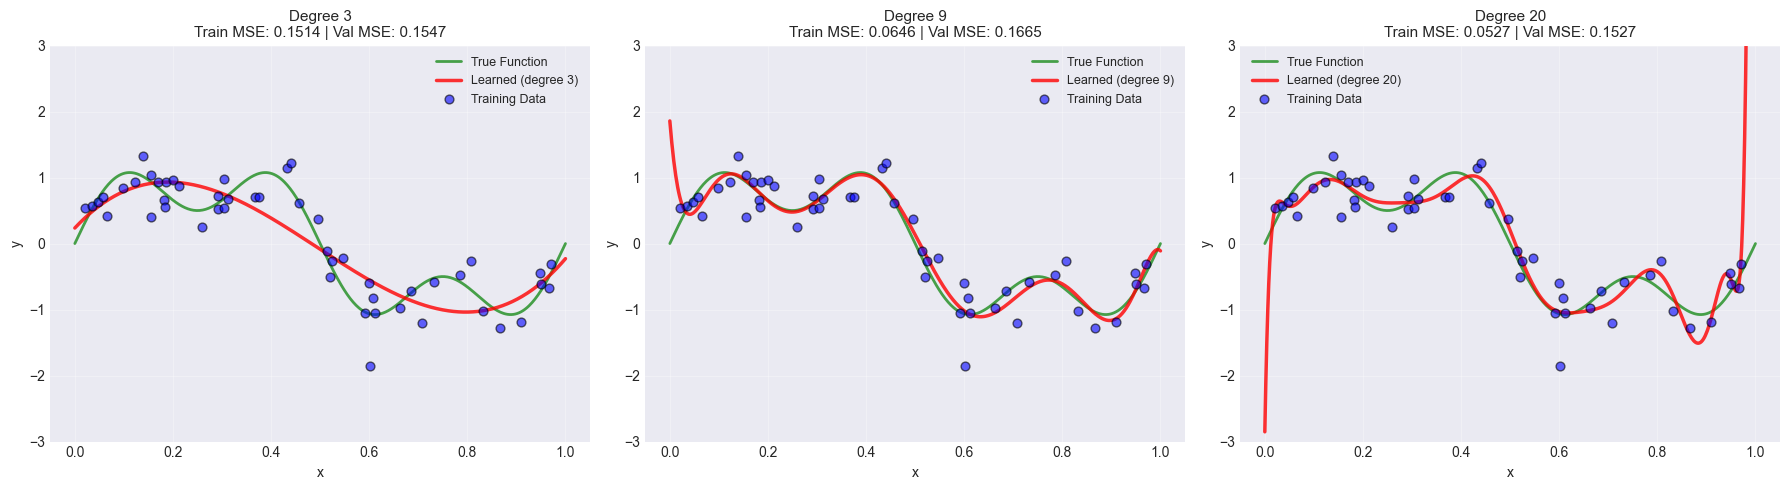

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, degree in enumerate(degrees):
    ax = axes[idx]
    results = models_results[degree]
    
    # True function
    ax.plot(X_grid, y_grid_true, 'g-', linewidth=2, 
            label='True Function', alpha=0.7)
    
    # Learned function
    ax.plot(X_grid, results['predictions'], 'r-', linewidth=2.5, 
            label=f'Learned (degree {degree})', alpha=0.8)
    
    # Training points
    ax.scatter(X_train, y_train, c='blue', s=40, alpha=0.6, 
               edgecolors='black', zorder=5, label='Training Data')
    
    # Title with errors
    ax.set_title(f'Degree {degree}\nTrain MSE: {results["train_error"]:.4f} | '
                 f'Val MSE: {results["val_error"]:.4f}', fontsize=11)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-3, 3])

plt.tight_layout()
plt.show()

## Part 3: Geometric Analysis in Function Space

### What We Observe:

1. **Degree 3 (Underfitting)**: 
   - Cannot capture the complexity of the true function
   - Both train and validation errors are high
   - Geometrically: The hypothesis space is too constrained

2. **Degree 9 (Good Fit)**:
   - Captures the underlying pattern
   - Low errors on both sets
   - Geometrically: Close to the true function in most regions

3. **Degree 20 (Overfitting)**:
   - **Low training error** (passes near all training points)
   - **High validation error** (wild oscillations between points)
   - Geometrically: High curvature, fits noise instead of signal

### Key Geometric Insight:
The degree-20 polynomial creates **high-frequency oscillations** in regions without training data. In function space, it's far from the true function despite passing through the training points.

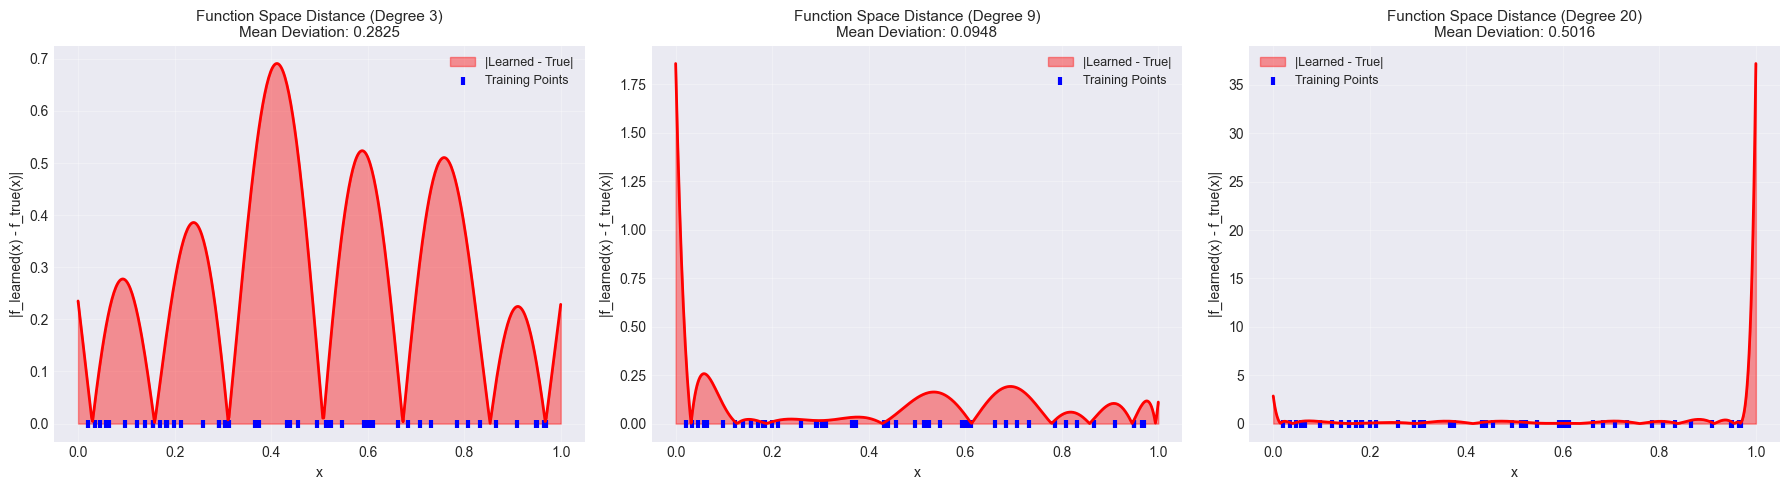


Observation:
High-degree polynomial has LARGE deviations between training points,
showing it has learned a geometrically different function.


In [6]:
# Calculate pointwise error from true function
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, degree in enumerate(degrees):
    ax = axes[idx]
    results = models_results[degree]
    
    # Calculate deviation from true function
    deviation = np.abs(results['predictions'] - y_grid_true)
    
    ax.fill_between(X_grid, 0, deviation, alpha=0.4, color='red', 
                     label='|Learned - True|')
    ax.plot(X_grid, deviation, 'r-', linewidth=2)
    
    # Mark training points
    ax.scatter(X_train, np.zeros_like(X_train), c='blue', s=40, 
               marker='|', linewidths=3, label='Training Points')
    
    ax.set_title(f'Function Space Distance (Degree {degree})\n'
                 f'Mean Deviation: {np.mean(deviation):.4f}', fontsize=11)
    ax.set_xlabel('x')
    ax.set_ylabel('|f_learned(x) - f_true(x)|')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservation:")
print("High-degree polynomial has LARGE deviations between training points,")
print("showing it has learned a geometrically different function.")

## Part 4: Curvature and Complexity

**Curvature** measures how quickly a function changes direction. High curvature = rapid oscillations.

Mathematically, curvature is related to the second derivative. Let's visualize:
- The learned function (f(x))
- Its first derivative (f'(x)) - rate of change
- Its second derivative (f''(x)) - curvature

High curvature between training points is the geometric signature of overfitting.

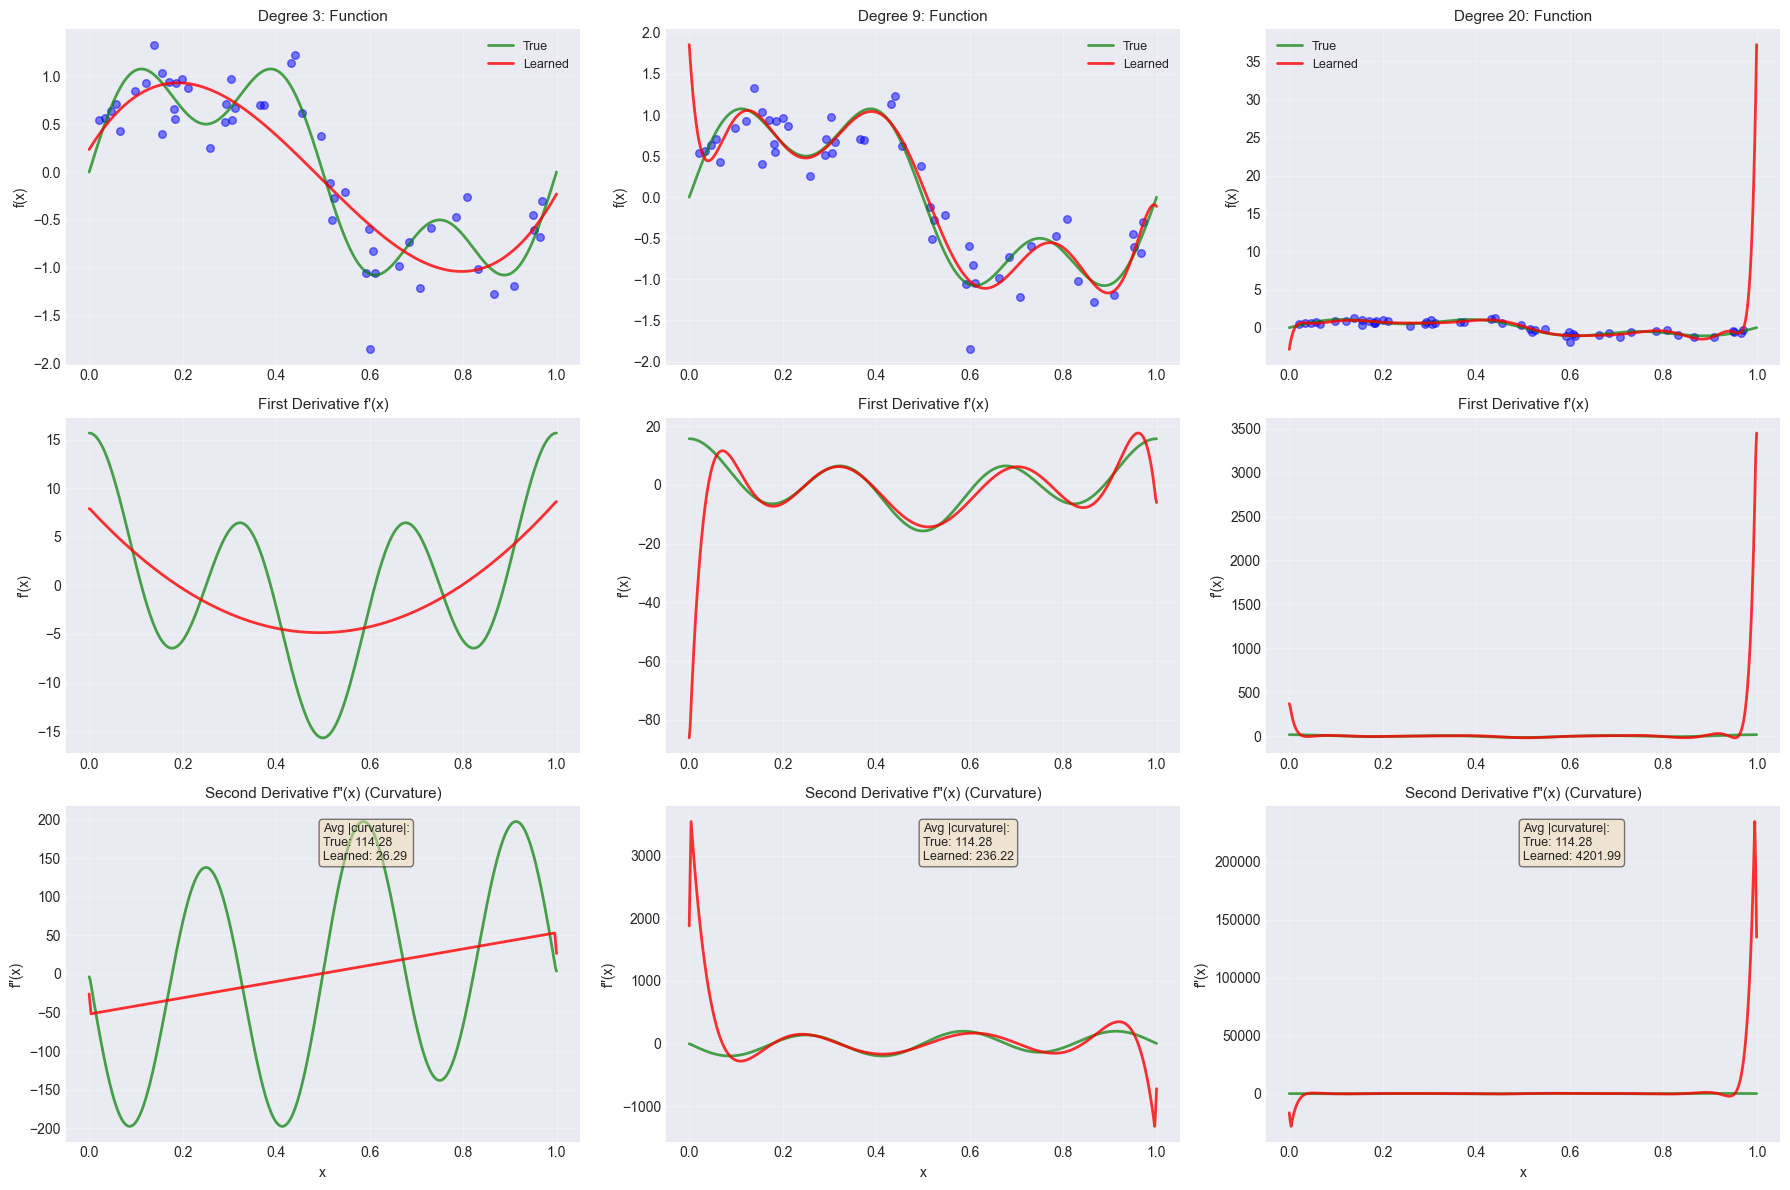

In [7]:
def numerical_derivative(x, y, order=1):
    """Compute numerical derivatives"""
    if order == 1:
        return np.gradient(y, x)
    elif order == 2:
        dy = np.gradient(y, x)
        return np.gradient(dy, x)

fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for col_idx, degree in enumerate(degrees):
    results = models_results[degree]
    y_pred = results['predictions']
    
    # Row 0: Function itself
    axes[0, col_idx].plot(X_grid, y_grid_true, 'g-', linewidth=2, 
                          label='True', alpha=0.7)
    axes[0, col_idx].plot(X_grid, y_pred, 'r-', linewidth=2, 
                          label='Learned', alpha=0.8)
    axes[0, col_idx].scatter(X_train, y_train, c='blue', s=30, alpha=0.5)
    axes[0, col_idx].set_title(f'Degree {degree}: Function', fontsize=11)
    axes[0, col_idx].set_ylabel('f(x)')
    axes[0, col_idx].legend(fontsize=9)
    axes[0, col_idx].grid(True, alpha=0.3)
    
    # Row 1: First derivative
    dy_true = numerical_derivative(X_grid, y_grid_true, order=1)
    dy_pred = numerical_derivative(X_grid, y_pred, order=1)
    
    axes[1, col_idx].plot(X_grid, dy_true, 'g-', linewidth=2, alpha=0.7)
    axes[1, col_idx].plot(X_grid, dy_pred, 'r-', linewidth=2, alpha=0.8)
    axes[1, col_idx].set_title(f"First Derivative f'(x)", fontsize=11)
    axes[1, col_idx].set_ylabel("f'(x)")
    axes[1, col_idx].grid(True, alpha=0.3)
    
    # Row 2: Second derivative (curvature)
    d2y_true = numerical_derivative(X_grid, y_grid_true, order=2)
    d2y_pred = numerical_derivative(X_grid, y_pred, order=2)
    
    axes[2, col_idx].plot(X_grid, d2y_true, 'g-', linewidth=2, alpha=0.7)
    axes[2, col_idx].plot(X_grid, d2y_pred, 'r-', linewidth=2, alpha=0.8)
    axes[2, col_idx].set_title(f'Second Derivative f"(x) (Curvature)', fontsize=11)
    axes[2, col_idx].set_ylabel('f"(x)')
    axes[2, col_idx].set_xlabel('x')
    axes[2, col_idx].grid(True, alpha=0.3)
    
    # Calculate curvature metrics
    curvature_true = np.mean(np.abs(d2y_true))
    curvature_pred = np.mean(np.abs(d2y_pred))
    axes[2, col_idx].text(0.5, 0.95, 
                          f'Avg |curvature|:\nTrue: {curvature_true:.2f}\nLearned: {curvature_pred:.2f}',
                          transform=axes[2, col_idx].transAxes,
                          verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                          fontsize=9)

plt.tight_layout()
plt.show()

## Part 5: Hypothesis Space Geometry (2D Visualization)

Let's visualize the **hypothesis space** geometrically. Each function can be represented as a point in a high-dimensional space where:
- Each dimension corresponds to a function value at a specific location
- Training constrains the function to pass near certain points
- The model searches for a function in this space

We'll project this into 2D using function values at two different x locations.

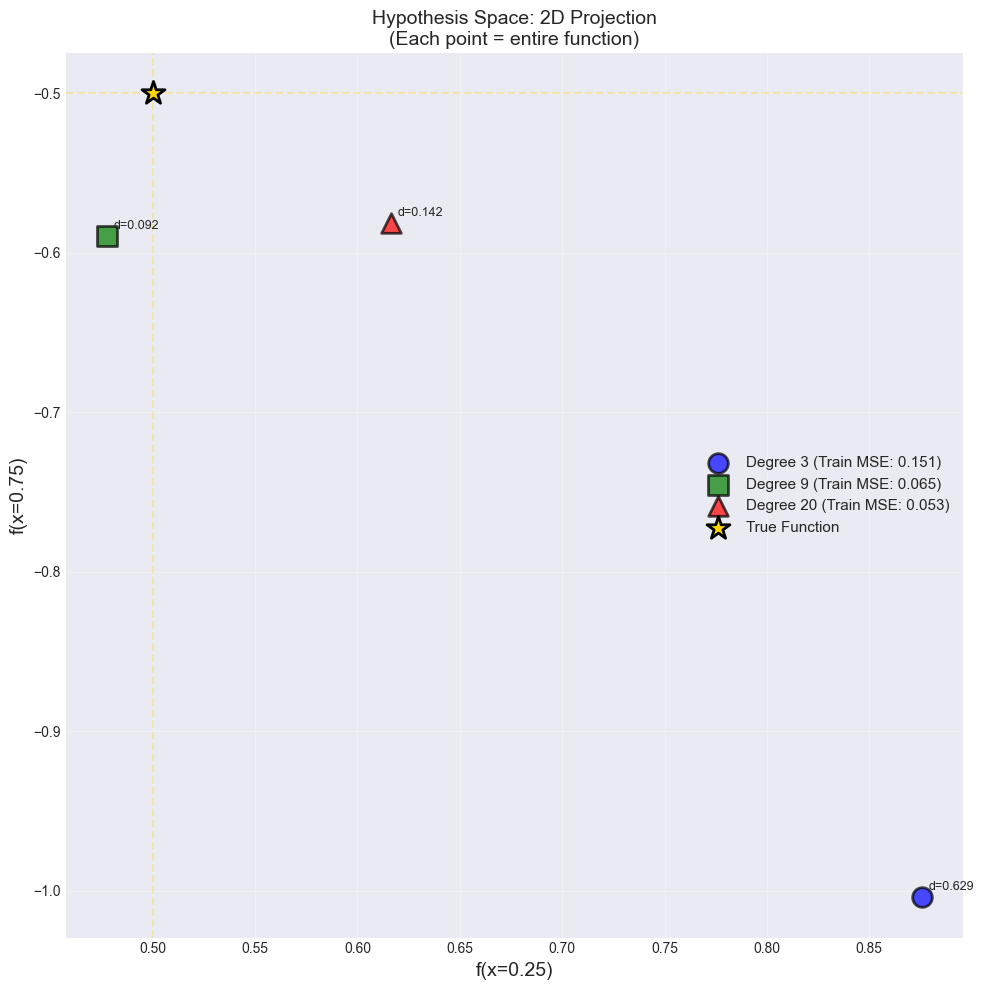


Interpretation:
- Each point represents an entire function
- Distance from gold star = how different the learned function is from truth
- Degree-20 may have low training error but is geometrically far from truth


In [8]:
# Choose two x locations for 2D projection
x1, x2 = 0.25, 0.75
idx1 = np.argmin(np.abs(X_grid - x1))
idx2 = np.argmin(np.abs(X_grid - x2))

# True function values at these points
true_f1 = y_grid_true[idx1]
true_f2 = y_grid_true[idx2]

# Collect learned function values
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

colors = {3: 'blue', 9: 'green', 20: 'red'}
markers = {3: 'o', 9: 's', 20: '^'}

for degree in degrees:
    results = models_results[degree]
    f1 = results['predictions'][idx1]
    f2 = results['predictions'][idx2]
    
    ax.scatter(f1, f2, s=200, c=colors[degree], marker=markers[degree],
               alpha=0.7, edgecolors='black', linewidths=2,
               label=f'Degree {degree} (Train MSE: {results["train_error"]:.3f})')

# True function point
ax.scatter(true_f1, true_f2, s=300, c='gold', marker='*',
           edgecolors='black', linewidths=2, label='True Function', zorder=10)

ax.set_xlabel(f'f(x={x1})', fontsize=14)
ax.set_ylabel(f'f(x={x2})', fontsize=14)
ax.set_title('Hypothesis Space: 2D Projection\n(Each point = entire function)', 
             fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.axhline(true_f2, color='gold', linestyle='--', alpha=0.3)
ax.axvline(true_f1, color='gold', linestyle='--', alpha=0.3)

# Add distance annotations
for degree in degrees:
    results = models_results[degree]
    f1 = results['predictions'][idx1]
    f2 = results['predictions'][idx2]
    distance = np.sqrt((f1 - true_f1)**2 + (f2 - true_f2)**2)
    ax.annotate(f'd={distance:.3f}', 
                xy=(f1, f2), xytext=(5, 5),
                textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Each point represents an entire function")
print("- Distance from gold star = how different the learned function is from truth")
print("- Degree-20 may have low training error but is geometrically far from truth")

## Part 6: Fitting Signal vs. Fitting Noise

Let's decompose what each model learns:
- **Signal**: The true underlying pattern (smooth function)
- **Noise**: Random perturbations in training data

We'll visualize how much of each component the models fit.

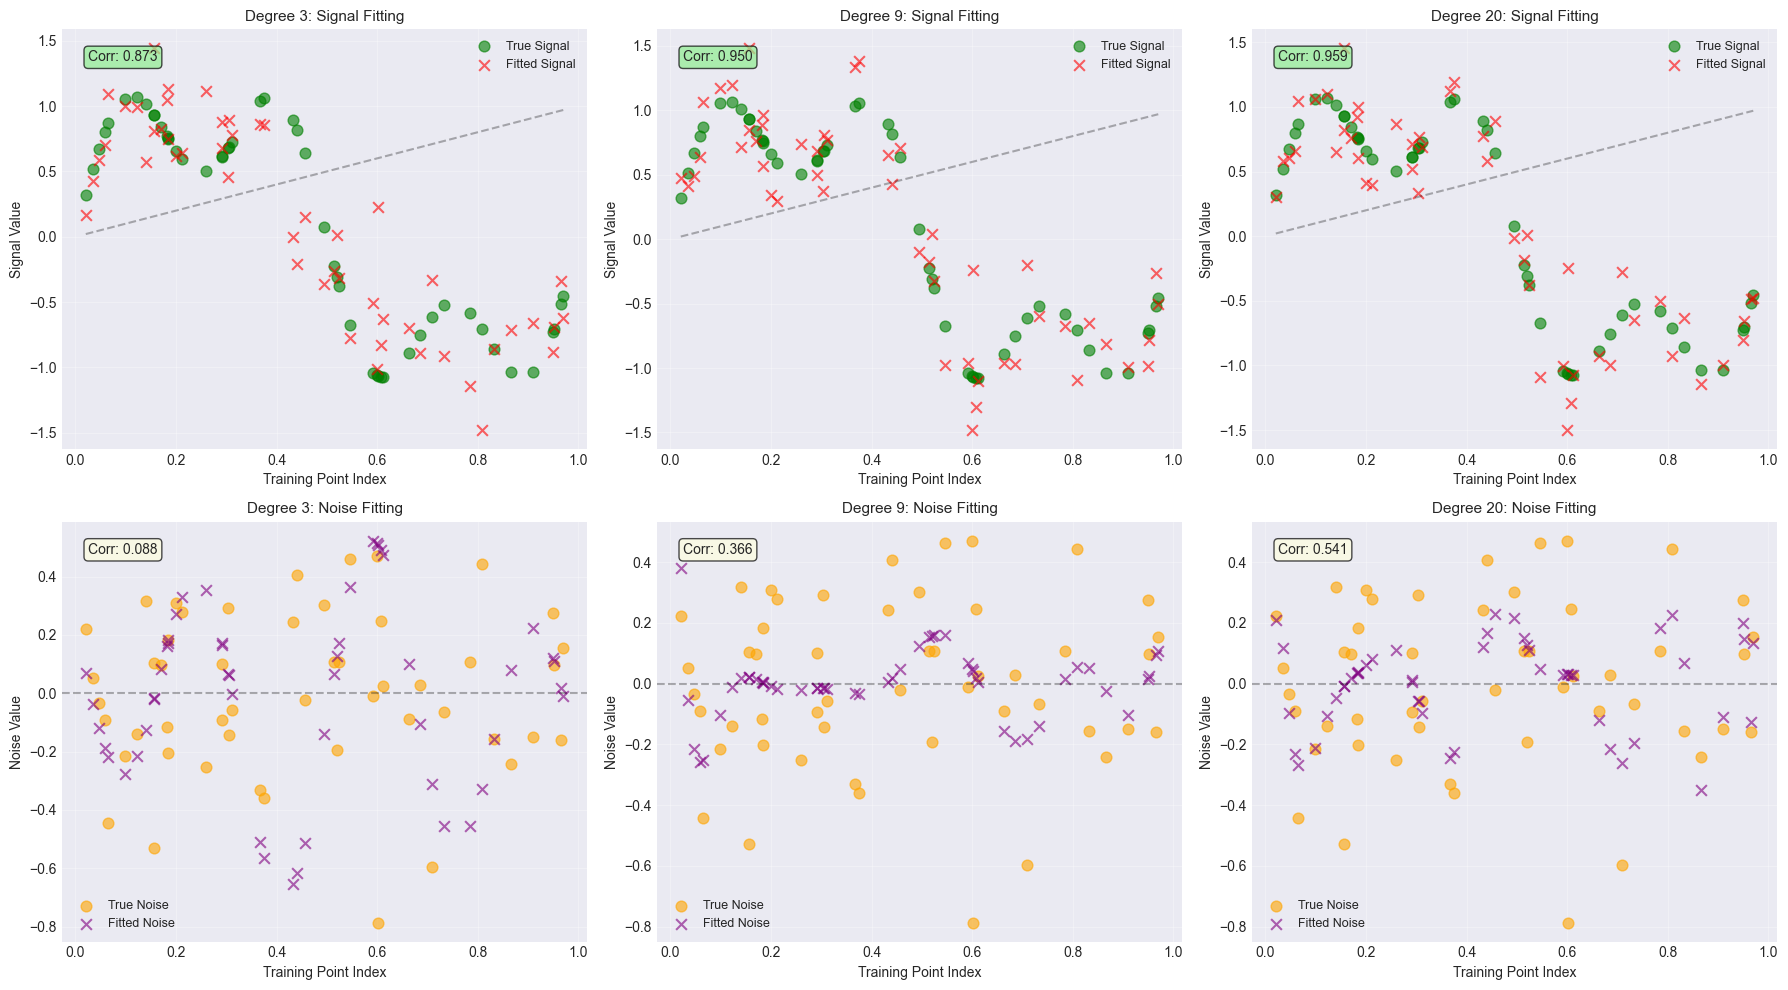


Observation:
High-degree polynomials show high correlation with NOISE,
meaning they've learned the random perturbations, not just the pattern.


In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for col_idx, degree in enumerate(degrees):
    results = models_results[degree]
    y_pred = results['predictions']
    
    # Get predictions at training points
    _, y_train_pred, _, _ = fit_polynomial(X_train, y_train, X_train, degree)
    
    # Decompose training predictions
    signal_component = y_true_train  # True function values at training points
    noise_component = y_train - y_true_train  # Noise in training data
    
    fitted_signal = y_train_pred - noise_component  # Approx how much signal was fit
    fitted_noise = y_train_pred - signal_component  # Approx how much noise was fit
    
    # Top row: Signal fitting
    axes[0, col_idx].scatter(X_train, signal_component, c='green', s=60, 
                             alpha=0.6, label='True Signal', marker='o')
    axes[0, col_idx].scatter(X_train, fitted_signal, c='red', s=60, 
                             alpha=0.6, label='Fitted Signal', marker='x')
    axes[0, col_idx].plot([min(X_train), max(X_train)], 
                          [min(X_train), max(X_train)], 
                          'k--', alpha=0.3)
    axes[0, col_idx].set_title(f'Degree {degree}: Signal Fitting', fontsize=11)
    axes[0, col_idx].set_xlabel('Training Point Index')
    axes[0, col_idx].set_ylabel('Signal Value')
    axes[0, col_idx].legend(fontsize=9)
    axes[0, col_idx].grid(True, alpha=0.3)
    
    # Bottom row: Noise fitting
    axes[1, col_idx].scatter(X_train, noise_component, c='orange', s=60, 
                             alpha=0.6, label='True Noise', marker='o')
    axes[1, col_idx].scatter(X_train, fitted_noise, c='purple', s=60, 
                             alpha=0.6, label='Fitted Noise', marker='x')
    axes[1, col_idx].axhline(0, color='black', linestyle='--', alpha=0.3)
    axes[1, col_idx].set_title(f'Degree {degree}: Noise Fitting', fontsize=11)
    axes[1, col_idx].set_xlabel('Training Point Index')
    axes[1, col_idx].set_ylabel('Noise Value')
    axes[1, col_idx].legend(fontsize=9)
    axes[1, col_idx].grid(True, alpha=0.3)
    
    # Calculate correlation
    signal_corr = np.corrcoef(signal_component, fitted_signal)[0, 1]
    noise_corr = np.corrcoef(noise_component, fitted_noise)[0, 1]
    
    axes[0, col_idx].text(0.05, 0.95, f'Corr: {signal_corr:.3f}',
                          transform=axes[0, col_idx].transAxes,
                          verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
                          fontsize=10)
    
    axes[1, col_idx].text(0.05, 0.95, f'Corr: {noise_corr:.3f}',
                          transform=axes[1, col_idx].transAxes,
                          verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7),
                          fontsize=10)

plt.tight_layout()
plt.show()

print("\nObservation:")
print("High-degree polynomials show high correlation with NOISE,")
print("meaning they've learned the random perturbations, not just the pattern.")

## Summary: Geometric Interpretation of Low Train Error + High Val Error

### What We've Shown:

1. **Function Space Distance**: 
   - Overfit models create functions that are geometrically **far** from the true function
   - Despite low training error, they diverge significantly between training points

2. **High Curvature**:
   - Overfit models have **excessive curvature** (high second derivatives)
   - This creates oscillations that fit training noise but fail to generalize

3. **Hypothesis Space**:
   - In the space of all possible functions, overfit models lie far from the true function
   - Training data alone doesn't constrain them to the right region

4. **Noise vs Signal**:
   - Complex models can fit both signal AND noise
   - Low training error means fitting EVERYTHING, including noise
   - High validation error reveals that noise patterns don't repeat

### Key Geometric Insight:

**"Overfitting" geometrically means**: The learned function f̂(x) has high-frequency components or high curvature that make it:
- Pass through (or near) all training points → low training error
- Deviate significantly from the true function f*(x) in interpolation regions → high validation error

The model has learned a **different function** from a different part of hypothesis space, not just a "noisy version" of the right function.

### Mathematical Formulation:
```
Training Error ≈ 0  ⟹  f̂(x_train) ≈ y_train
Validation Error ≫ 0  ⟹  ||f̂(x) - f*(x)||_L2 is large

This happens when f̂ has high complexity/curvature:
∫ |f̂''(x)|² dx ≫ ∫ |f*''(x)|² dx
```

### Remedies:
- Regularization (penalty on curvature/complexity)
- More training data (constrains function in more regions)
- Simpler models (smaller hypothesis space)
- Ensemble methods (average out high-frequency noise)

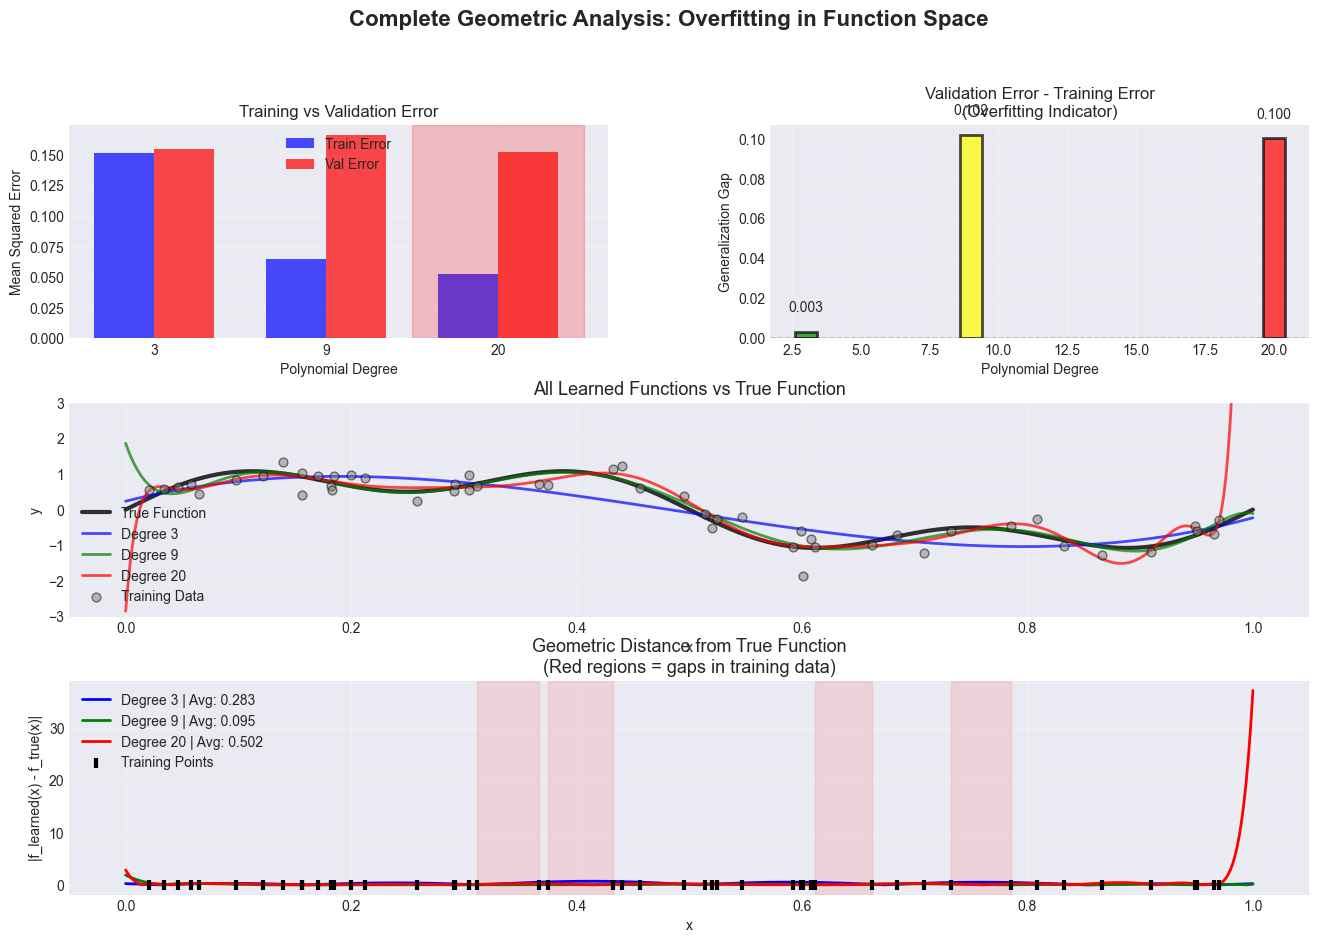


CONCLUSION:
Degree 20 achieves training MSE of 0.0527
But validation MSE is 0.1527

Geometrically, this is because the learned function has:
  - Mean deviation from truth: 0.502
  - High curvature between training points
  - Fits noise patterns that don't generalize


In [10]:
# Create a comprehensive summary visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Top left: Training and validation errors
ax1 = fig.add_subplot(gs[0, 0])
train_errors = [models_results[d]['train_error'] for d in degrees]
val_errors = [models_results[d]['val_error'] for d in degrees]

x_pos = np.arange(len(degrees))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, train_errors, width, label='Train Error', 
                color='blue', alpha=0.7)
bars2 = ax1.bar(x_pos + width/2, val_errors, width, label='Val Error', 
                color='red', alpha=0.7)

ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Training vs Validation Error')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(degrees)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Highlight overfitting regime
ax1.axvspan(1.5, 2.5, alpha=0.2, color='red', label='Overfitting')

# Top right: Generalization gap
ax2 = fig.add_subplot(gs[0, 1])
gen_gaps = [val_errors[i] - train_errors[i] for i in range(len(degrees))]

bars = ax2.bar(degrees, gen_gaps, color=['green', 'yellow', 'red'], 
               alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_xlabel('Polynomial Degree')
ax2.set_ylabel('Generalization Gap')
ax2.set_title('Validation Error - Training Error\n(Overfitting Indicator)')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.grid(True, alpha=0.3)

for i, (degree, gap) in enumerate(zip(degrees, gen_gaps)):
    ax2.text(degree, gap + 0.01, f'{gap:.3f}', ha='center', fontsize=10)

# Middle: All learned functions
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(X_grid, y_grid_true, 'k-', linewidth=3, label='True Function', alpha=0.8)

colors_funcs = {3: 'blue', 9: 'green', 20: 'red'}
for degree in degrees:
    results = models_results[degree]
    ax3.plot(X_grid, results['predictions'], 
             color=colors_funcs[degree], linewidth=2, 
             label=f'Degree {degree}', alpha=0.7)

ax3.scatter(X_train, y_train, c='gray', s=40, alpha=0.5, 
            edgecolors='black', zorder=5, label='Training Data')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title('All Learned Functions vs True Function', fontsize=13)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_ylim([-3, 3])

# Bottom: Distance from true function
ax4 = fig.add_subplot(gs[2, :])
for degree in degrees:
    results = models_results[degree]
    deviation = np.abs(results['predictions'] - y_grid_true)
    ax4.plot(X_grid, deviation, linewidth=2, 
             label=f'Degree {degree} | Avg: {np.mean(deviation):.3f}',
             color=colors_funcs[degree])

# Shade regions without training data
for i in range(len(X_train)-1):
    if X_train[i+1] - X_train[i] > 0.05:  # Gap in training data
        ax4.axvspan(X_train[i], X_train[i+1], alpha=0.1, color='red')

ax4.scatter(X_train, np.zeros_like(X_train), c='black', s=50, 
            marker='|', linewidths=3, label='Training Points', zorder=10)
ax4.set_xlabel('x')
ax4.set_ylabel('|f_learned(x) - f_true(x)|')
ax4.set_title('Geometric Distance from True Function\n(Red regions = gaps in training data)', 
              fontsize=13)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.suptitle('Complete Geometric Analysis: Overfitting in Function Space', 
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

print("\n" + "="*70)
print("CONCLUSION:")
print("="*70)
print(f"Degree 20 achieves training MSE of {models_results[20]['train_error']:.4f}")
print(f"But validation MSE is {models_results[20]['val_error']:.4f}")
print(f"\nGeometrically, this is because the learned function has:")
print(f"  - Mean deviation from truth: {np.mean(np.abs(models_results[20]['predictions'] - y_grid_true)):.3f}")
print(f"  - High curvature between training points")
print(f"  - Fits noise patterns that don't generalize")
print("="*70)